In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

import datetime

import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg

from geopy.distance import geodesic
from scipy.spatial import cKDTree

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.10f' % x)


# Read in School Data

In [64]:
schools = pd.read_excel("Schools_Geocoded.xlsx")
schools.head(1)

,ID,Address,City,State,MAR_MARID,MAR_MATCHADDRESS,MAR_ALIAS,LATITUDE,LONGITUDE,MAR_WARD
0,1,Anacostia High School,Washington,DC,155922.0000000000,1601 16TH STREET SE,ANACOSTIA HIGH SCHOOL,38.8700840600,-76.9830772500,Ward 8


In [65]:
import os
os.getcwd

<function posix.getcwd()>

# Read in Crime Data

### Crime Data is aggregated to the block face level and stored as point data on the block centroid, so distance is school point to block centroid point

In [66]:
import json

# One GeoJSON file for each year of crime data 
file_names = ['Crime_Data/Crime_Incidents_in_2018.geojson', 
              'Crime_Data/Crime_Incidents_in_2019.geojson', 
              'Crime_Data/Crime_Incidents_in_2020.geojson', 
              'Crime_Data/Crime_Incidents_in_2021.geojson', 
              'Crime_Data/Crime_Incidents_in_2022.geojson', 
              'Crime_Data/Crime_Incidents_in_2023.geojson']

features = []

# Loop through each file
for file_name in file_names:
    with open(file_name, 'r') as file:
        data = json.load(file)
        file_features = data['features']
        for feature in file_features:
            features.append(feature)


# Create a GeoJSON feature collection
combined_geojson = {
    "type": "FeatureCollection",
    "features": features
}

# Write the full crime GeoJSON file
with open('Crime_Data/Crime_Incidents_2018_2023.geojson', 'w') as outfile:
    json.dump(combined_geojson, outfile)

In [67]:
# Create Crime Dataframe
crime_data = {
    'CCN': [feature['properties']['CCN'] for feature in features],
    'REPORT_DAT': [feature['properties']['REPORT_DAT'] for feature in features],
    'SHIFT': [feature['properties']['SHIFT'] for feature in features],
    'METHOD': [feature['properties']['METHOD'] for feature in features],
    'OFFENSE': [feature['properties']['OFFENSE'] for feature in features],
    'BLOCK': [feature['properties']['BLOCK'] for feature in features],
    'WARD': [feature['properties']['WARD'] for feature in features],
    'ANC': [feature['properties']['ANC'] for feature in features],
    'DISTRICT': [feature['properties']['DISTRICT'] for feature in features],
    'PSA': [feature['properties']['PSA'] for feature in features],
    'NEIGHBORHOOD_CLUSTER': [feature['properties']['NEIGHBORHOOD_CLUSTER'] for feature in features],
    'BLOCK_GROUP': [feature['properties']['BLOCK_GROUP'] for feature in features],
    'CENSUS_TRACT': [feature['properties']['CENSUS_TRACT'] for feature in features],
    'VOTING_PRECINCT': [feature['properties']['VOTING_PRECINCT'] for feature in features],
    'LATITUDE': [feature['geometry']['coordinates'][1] for feature in features],
    'LONGITUDE': [feature['geometry']['coordinates'][0] for feature in features]
}


crime_data = pd.DataFrame(crime_data)
crime_data.shape

(185454, 16)

# Filter to Violent Crimes

Only interested in violent crimes

In [68]:
# All Crimes
crime_data["OFFENSE"].value_counts()

THEFT/OTHER                   75663
THEFT F/AUTO                  54842
MOTOR VEHICLE THEFT           21854
ROBBERY                       13839
ASSAULT W/DANGEROUS WEAPON     9318
BURGLARY                       7453
HOMICIDE                       1223
SEX ABUSE                      1217
ARSON                            45
Name: OFFENSE, dtype: int64

In [69]:
# Violent Crimes
crime_data = crime_data[crime_data["OFFENSE"].isin(["ASSAULT W/DANGEROUS WEAPON", "ROBBERY", "HOMICIDE", "SEX ABUSE"])]
crime_data["OFFENSE"].value_counts()

ROBBERY                       13839
ASSAULT W/DANGEROUS WEAPON     9318
HOMICIDE                       1223
SEX ABUSE                      1217
Name: OFFENSE, dtype: int64

# Filter to Weekdays

Only weekdays should be counted for crimes near schoools

In [70]:
crime_data['REPORT_DAT'] = pd.to_datetime(crime_data['REPORT_DAT'])
crime_data['REPORT_DATE'] = crime_data['REPORT_DAT'].dt.strftime('%Y-%m-%d')
crime_data['REPORT_DAT_WEEKDAY'] = crime_data['REPORT_DAT'].dt.weekday

In [71]:
crime_data = crime_data[crime_data['REPORT_DAT_WEEKDAY'] < 5]

In [72]:
crime_data['REPORT_DAT_WEEKDAY'].value_counts()

1    3573
0    3537
4    3471
2    3459
3    3368
Name: REPORT_DAT_WEEKDAY, dtype: int64

# Filter to School Years

Only interested in dates within the school year including winter holidays


In [73]:
mask = (
          ((crime_data.REPORT_DATE >= '2018-08-15') & (crime_data.REPORT_DATE <= '2019-06-15')) 
        | ((crime_data.REPORT_DATE >= '2019-08-15') & (crime_data.REPORT_DATE <= '2020-06-15')) 
        | ((crime_data.REPORT_DATE >= '2020-08-15') & (crime_data.REPORT_DATE <= '2021-06-15'))
        | ((crime_data.REPORT_DATE >= '2021-08-15') & (crime_data.REPORT_DATE <= '2022-06-15'))
        | ((crime_data.REPORT_DATE >= '2022-08-15') & (crime_data.REPORT_DATE <= '2023-06-15'))
       )

crime_data_sub = crime_data.loc[mask]

# Create School Year 

This will be used to split crime data by school year to look for trends

In [74]:
crime_data_sub["SCHOOL_YEAR"] = np.where((crime_data_sub.REPORT_DATE >= '2018-08-15') & (crime_data_sub.REPORT_DATE <= '2019-06-15'),"2018-2019",
                                 np.where((crime_data_sub.REPORT_DATE >= '2019-08-15') & (crime_data_sub.REPORT_DATE <= '2020-06-15'),"2019-2020",
                                 np.where((crime_data_sub.REPORT_DATE >= '2020-08-15') & (crime_data_sub.REPORT_DATE <= '2021-06-15'),"2020-2021",
                                 np.where((crime_data_sub.REPORT_DATE >= '2021-08-15') & (crime_data_sub.REPORT_DATE <= '2022-06-15'),"2021-2022",
                                 np.where((crime_data_sub.REPORT_DATE >= '2022-08-15') & (crime_data_sub.REPORT_DATE <= '2023-06-15'),"2022-2023",
                                 "None")))))

crime_data_sub["SCHOOL_YEAR"].value_counts()


/tmp/ipykernel_261166/3591723871.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data_sub["SCHOOL_YEAR"] = np.where((crime_data_sub.REPORT_DATE >= '2018-08-15') & (crime_data_sub.REPORT_DATE <= '2019-06-15'),"2018-2019",


2022-2023    2457
2021-2022    2444
2018-2019    2219
2020-2021    2206
2019-2020    2202
Name: SCHOOL_YEAR, dtype: int64

# Get Distance Between Each Crime and Nearest School

In [75]:
#Get geodesic distance in feet between two points
def calculate_distance(point1, point2):
    return geodesic(point1, point2).feet

In [76]:
# Create a KDTree for schools 
schools_kdtree = cKDTree(schools[['LATITUDE', 'LONGITUDE']])

# Find the distance to the nearest school for each crime
nearest_distances = []
for _, crime_row in crime_data_sub.iterrows():
    crime_coords = (crime_row['LATITUDE'], crime_row['LONGITUDE'])
    _, nearest_school_idx = schools_kdtree.query(crime_coords)
    nearest_school_coords = schools.iloc[nearest_school_idx][['LATITUDE', 'LONGITUDE']]
    distance = calculate_distance(crime_coords, nearest_school_coords)
    nearest_distances.append(distance)

# Add nearest distance to school to crimes dataframe
crime_data_sub['DISTANCE_TO_SCHOOL'] = nearest_distances


# Get counts of crimes at each block centroid
crime_data_sub_grouped = crime_data_sub.groupby(['LONGITUDE', 'LATITUDE', 'DISTANCE_TO_SCHOOL']).size().reset_index(name='TOTAL_CRIMES')

print(crime_data_sub_grouped.head())

       LONGITUDE      LATITUDE  DISTANCE_TO_SCHOOL  TOTAL_CRIMES
0 -77.1109318173 38.9330040008    12447.8613785931             1
1 -77.1063476876 38.9294409693    12263.3369189694             1
2 -77.1034491276 38.9268311582    12386.6320844510             2
3 -77.1026185376 38.9426865129     8619.4339447458             1
4 -77.1001500597 38.9345001080     9716.4390556158             1


/tmp/ipykernel_261166/1944047254.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data_sub['DISTANCE_TO_SCHOOL'] = nearest_distances


# Filter to Crimes Within 500 Feet of School

In [77]:
crimes_within_school_zones = crime_data_sub[crime_data_sub['DISTANCE_TO_SCHOOL'] <= 500]
print(crimes_within_school_zones.shape)
print(crime_data_sub.shape)

(586, 20)
(11528, 20)


In [78]:
crimes_within_school_zones_grouped = crimes_within_school_zones.groupby(['LONGITUDE', 'LATITUDE', 'DISTANCE_TO_SCHOOL']).size().reset_index(name='TOTAL_CRIMES')
crimes_within_school_zones_grouped.head()

,LONGITUDE,LATITUDE,DISTANCE_TO_SCHOOL,TOTAL_CRIMES
0,-77.0754289845,38.9523460837,144.8177990437,1
1,-77.0369189009,38.9287178180,448.0449708757,1
2,-77.0364812108,38.9298079612,313.7639653121,17
3,-77.0364807637,38.9289341551,300.7281840965,1
4,-77.0354195963,38.9286462155,254.5792429698,3


# Mapping

In [79]:
import folium

In [80]:
# Create a map centered around the mean latitude and longitude of the points
mymap = folium.Map(location=[crimes_within_school_zones_grouped['LATITUDE'].mean(), crimes_within_school_zones_grouped['LONGITUDE'].mean()], zoom_start=2)

for index, row in crimes_within_school_zones_grouped.iterrows():
    radius = row['TOTAL_CRIMES'] / 5  # Adjust the divisor as needed for suitable radius scaling
    folium.CircleMarker(location=[row['LATITUDE'], row['LONGITUDE']], radius=radius, color='red', fill=True, fill_color='red', fill_opacity=0.7, popup=row['TOTAL_CRIMES']).add_to(mymap)

    
for index, row in schools.iterrows():
    folium.CircleMarker(location=[row['LATITUDE'], row['LONGITUDE']], radius=5, color='green', fill=True, fill_color='green', fill_opacity=1, popup=row['Address']).add_to(mymap)

mymap.fit_bounds(mymap.get_bounds())
mymap

In [81]:
crime_data_sub['CLOSE_TO_SCHOOL'] = np.where(crime_data_sub['DISTANCE_TO_SCHOOL'] <= 500, "yes", "no")
crime_data_sub['CLOSE_TO_SCHOOL'].value_counts()

/tmp/ipykernel_261166/629991056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data_sub['CLOSE_TO_SCHOOL'] = np.where(crime_data_sub['DISTANCE_TO_SCHOOL'] <= 500, "yes", "no")


# Charts and Metrics
- Violent Crimes by School Year
- Total Monthly Offenses
- Violent Crimes per School

### Violent Crimes by School Year

In [23]:
crimes_near_schools = crime_data_sub[crime_data_sub['CLOSE_TO_SCHOOL'] == "yes"]
crimes_not_near_schools = crime_data_sub[crime_data_sub['CLOSE_TO_SCHOOL'] == "no"]
print(crimes_near_schools.shape)
print(crimes_not_near_schools.shape)

(586, 21)
(10942, 21)


In [29]:
offense_counts_by_school_year_near = pd.crosstab(crimes_near_schools['SCHOOL_YEAR'], crimes_near_schools['OFFENSE'], margins=True, margins_name = "Total")
offense_counts_by_school_year_near

OFFENSE,ASSAULT W/DANGEROUS WEAPON,HOMICIDE,ROBBERY,SEX ABUSE,Total
SCHOOL_YEAR,,,,,
2018-2019,50,1,64,3,118
2019-2020,41,7,65,2,115
2020-2021,41,10,41,5,97
2021-2022,49,6,57,6,118
2022-2023,58,9,68,3,138
Total,239,33,295,19,586


In [26]:
offense_counts_by_school_year_not_near = pd.crosstab(crimes_not_near_schools['SCHOOL_YEAR'], crimes_not_near_schools['OFFENSE'], margins=True, margins_name = "Total")
offense_counts_by_school_year_not_near

OFFENSE,ASSAULT W/DANGEROUS WEAPON,HOMICIDE,ROBBERY,SEX ABUSE,All
SCHOOL_YEAR,,,,,
2018-2019,863,76,1050,112,2101
2019-2020,816,85,1087,99,2087
2020-2021,836,109,1069,95,2109
2021-2022,828,134,1270,94,2326
2022-2023,731,119,1361,108,2319
All,4074,523,5837,508,10942


In [41]:
offense_counts_by_school_year_all = pd.crosstab(crime_data_sub['SCHOOL_YEAR'], crime_data_sub['OFFENSE'], values=crime_data_sub['CLOSE_TO_SCHOOL'], aggfunc = "count", margins=True, margins_name = "Total")
offense_counts_by_school_year_all

OFFENSE,ASSAULT W/DANGEROUS WEAPON,HOMICIDE,ROBBERY,SEX ABUSE,Total
SCHOOL_YEAR,,,,,
2018-2019,913,77,1114,115,2219
2019-2020,857,92,1152,101,2202
2020-2021,877,119,1110,100,2206
2021-2022,877,140,1327,100,2444
2022-2023,789,128,1429,111,2457
Total,4313,556,6132,527,11528


In [35]:
offense_counts_by_school_year_near_df = offense_counts_by_school_year_near.reset_index()
offense_counts_by_school_year_not_near_df = offense_counts_by_school_year_not_near.reset_index()
offense_counts_by_school_year_all_df = offense_counts_by_school_year_all.reset_index()

offense_counts_by_school_year_near_df.to_csv("School_Year_Results/Crimes_within_500_feet_of_school.csv", index = False)
offense_counts_by_school_year_not_near_df.to_csv("School_Year_Results/Crimes_not_within_500_feet_of_school.csv", index = False)
offense_counts_by_school_year_all_df.to_csv("School_Year_Results/All_Crimes.csv", index = False)

### Total Monthly Offenses

/tmp/ipykernel_261166/3775499337.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data_sub['MONTH_YEAR'] = crime_data_sub['REPORT_DAT'].dt.strftime('%m-%Y')
/tmp/ipykernel_261166/3775499337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data_sub['MONTH_YEAR'] = pd.to_datetime(crime_data_sub['MONTH_YEAR'], format='%m-%Y')


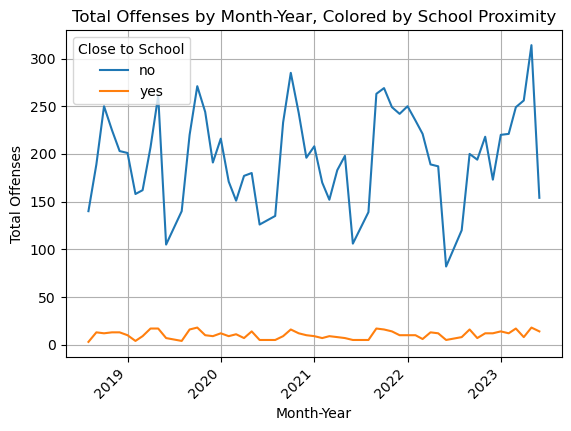

In [25]:
crime_data_sub['MONTH_YEAR'] = crime_data_sub['REPORT_DAT'].dt.strftime('%m-%Y')
crime_data_sub['MONTH_YEAR'] = pd.to_datetime(crime_data_sub['MONTH_YEAR'], format='%m-%Y')

crime_data_monthly = crime_data_sub.groupby(['MONTH_YEAR', 'CLOSE_TO_SCHOOL']).size().unstack(fill_value=0)

crime_data_monthly.plot(kind='line', marker=None, stacked=False)
plt.title('Total Offenses by Month-Year, Colored by School Proximity')
plt.xlabel('Month-Year')
plt.ylabel('Total Offenses')
plt.legend(title='Close to School')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [82]:
# Calculate Percent of All Violent Crimes That took place within 500 feet of a school
crime_data_monthly = crime_data_monthly.reset_index()
crime_data_monthly = crime_data_monthly.rename(columns = {"no": "NOT_WITHIN_500_FEET_OF_SCHOOL", "yes":"WITHIN_500_FEET_OF_SCHOOL"})

crime_data_monthly["PERCENT_CRIMES_WITHIN_500_FEET_OF_SCHOOL"] = crime_data_monthly["WITHIN_500_FEET_OF_SCHOOL"] / (crime_data_monthly["WITHIN_500_FEET_OF_SCHOOL"] + crime_data_monthly["NOT_WITHIN_500_FEET_OF_SCHOOL"]) * 100
crime_data_monthly.head(1)

NameError: name 'crime_data_monthly' is not defined

In [26]:
crime_data_sub['CLOSE_TO_SCHOOL'].value_counts()

no     10942
yes      586
Name: CLOSE_TO_SCHOOL, dtype: int64

### Violent Crimes per School
Some crimes occur within 500 feet of several schools, so expanding to each crime-school incident so those incidents get counted in both school totals

In [28]:
# Cross join so it results in a table with a row for crime-school combination
schools['key'] = 1
crime_data_sub['key'] = 1

crimes_per_school = pd.merge(schools, crime_data_sub, on='key')
crimes_per_school.drop('key', axis=1, inplace=True)

crimes_per_school.shape

/tmp/ipykernel_252137/2464322221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_data_sub['key'] = 1


(622512, 32)

In [80]:
crimes_per_school_sub = crimes_per_school[['Address', 'MAR_MATCHADDRESS', 'LATITUDE_x', 'LONGITUDE_x', 'CCN', 'REPORT_DATE', 'OFFENSE', 'LATITUDE_y', 'LONGITUDE_y']]
crimes_per_school_sub = crimes_per_school_sub.rename(columns = {"Address": "SCHOOL",
                                                                "LATITUDE_x": "LATITUDE_SCHOOL", 
                                                                "LONGITUDE_x":"LONGITUDE_SCHOOL", 
                                                                "LATITUDE_y": "LATITUDE_CRIME", 
                                                                "LONGITUDE_y":"LONGITUDE_CRIME"})

crimes_per_school_sub.head()

,SCHOOL,MAR_MATCHADDRESS,LATITUDE_SCHOOL,LONGITUDE_SCHOOL,CCN,REPORT_DATE,OFFENSE,LATITUDE_CRIME,LONGITUDE_CRIME
0,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,10251445,2020-09-11,HOMICIDE,38.8574912594,-76.9726506441
1,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,10147537,2020-12-21,HOMICIDE,38.8540859728,-76.9722256799
2,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,00016641,2020-01-28,THEFT F/AUTO,38.9118740217,-77.0307876903
3,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,18048023,2020-10-21,HOMICIDE,38.8216317990,-77.0017526415
4,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,19073083,2020-12-11,HOMICIDE,38.9288046379,-77.0045000976


In [83]:
# Get the distance between each crime and each school

def calculate_distance(row):
    school_coords = (row['LATITUDE_SCHOOL'], row['LONGITUDE_SCHOOL'])
    crime_coords = (row['LATITUDE_CRIME'], row['LONGITUDE_CRIME'])
    return geodesic(school_coords, crime_coords).feet

crimes_per_school_sub['DISTANCE'] = crimes_per_school_sub.apply(calculate_distance, axis=1)


In [85]:
# Filter to crimes within 500 feet of a school
crimes_per_school_sub_within_500 = crimes_per_school_sub[crimes_per_school_sub['DISTANCE'] <= 500]
crimes_per_school_sub_within_500.shape

(2846, 10)

In [84]:
crimes_per_school_sub_within_500.head()

,SCHOOL,MAR_MATCHADDRESS,LATITUDE_SCHOOL,LONGITUDE_SCHOOL,CCN,REPORT_DATE,OFFENSE,LATITUDE_CRIME,LONGITUDE_CRIME,DISTANCE
0,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,10251445,2020-09-11,HOMICIDE,38.8574912594,-76.9726506441,5463.5912279664
1,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,10147537,2020-12-21,HOMICIDE,38.8540859728,-76.9722256799,6595.4203551041
2,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,00016641,2020-01-28,THEFT F/AUTO,38.9118740217,-77.0307876903,20398.4249193431
3,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,18048023,2020-10-21,HOMICIDE,38.8216317990,-77.0017526415,18431.2408198234
4,Anacostia High School,1601 16TH STREET SE,38.8700840600,-76.9830772500,19073083,2020-12-11,HOMICIDE,38.9288046379,-77.0045000976,22239.2017427774


In [87]:
# Count of crimes within 500 feet per school
crimes_per_school_sub_within_500_count = crimes_per_school_sub_within_500.groupby(['SCHOOL']).size().reset_index(name='TOTAL_CRIMES')
crimes_per_school_sub_within_500_count

,SCHOOL,TOTAL_CRIMES
0,Anacostia High School,35
1,Ballou High School,11
2,Ballou STAY High School,11
3,Bard,26
4,Capital City Middle School & High School,10
5,Cardozo Education Campus,87
6,Center City PCS - Congress Heights,12
7,Cesar Chavez PCS for Public Policy - Parkside ...,128
8,Columbia Heights Education Campus,112
9,Coolidge High School,17
